In [1]:
import sys, os

sys.path.append(os.path.join("..", "src"))

from sindy_core import SINDyModel, SINDyConfig
from derivatives import (  # 👈 new
    finite_difference_derivative,
    sgolay_derivative,
    tv_derivative,
)
from systems import LorenzDefinition
from plotting import (
    plot_time_series,
    plot_phase,
    plot_3d,
    plot_time_series_comparison,
    plot_3d_comparison,
    plot_error_time_series,
)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

=== SINDy model using finite-difference derivatives (baseline) ===
dx/dt = -10.1142*x + 10.0649*y
dy/dt = -0.011419 + 28.429*x - 1.16115*y - 1.03231*x z
dz/dt = -0.181633 - 0.0336519*x - 2.63319*z - 0.0129922*x^2 + 1.03085*x y


(<Figure size 800x300 with 1 Axes>,
 <Axes: title={'center': 'Trajectory Error $\\|x_{\\mathrm{true}} - x_{\\mathrm{SINDy}}\\|$'}, xlabel='t', ylabel='error'>)

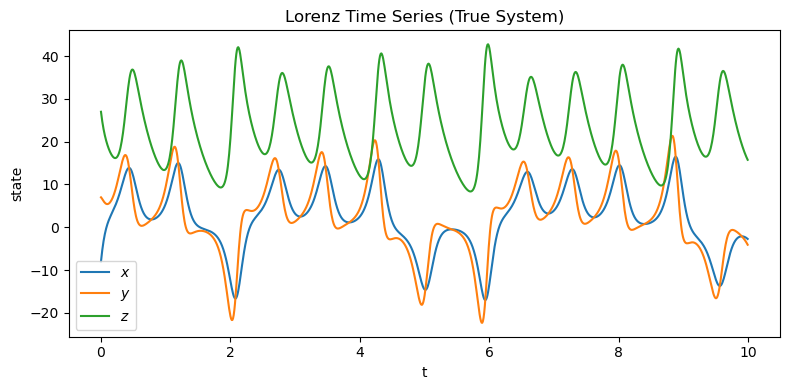

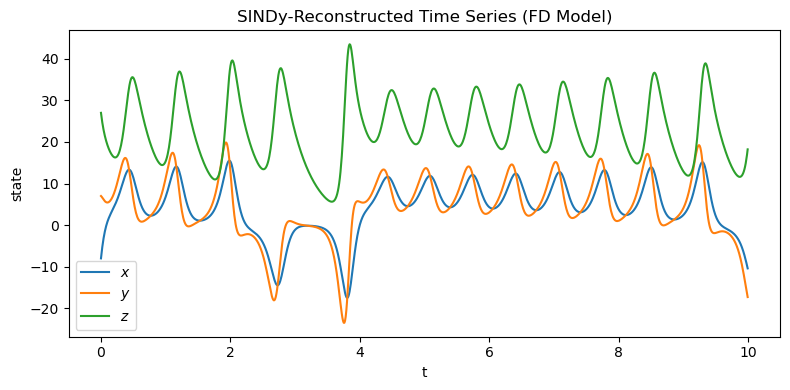

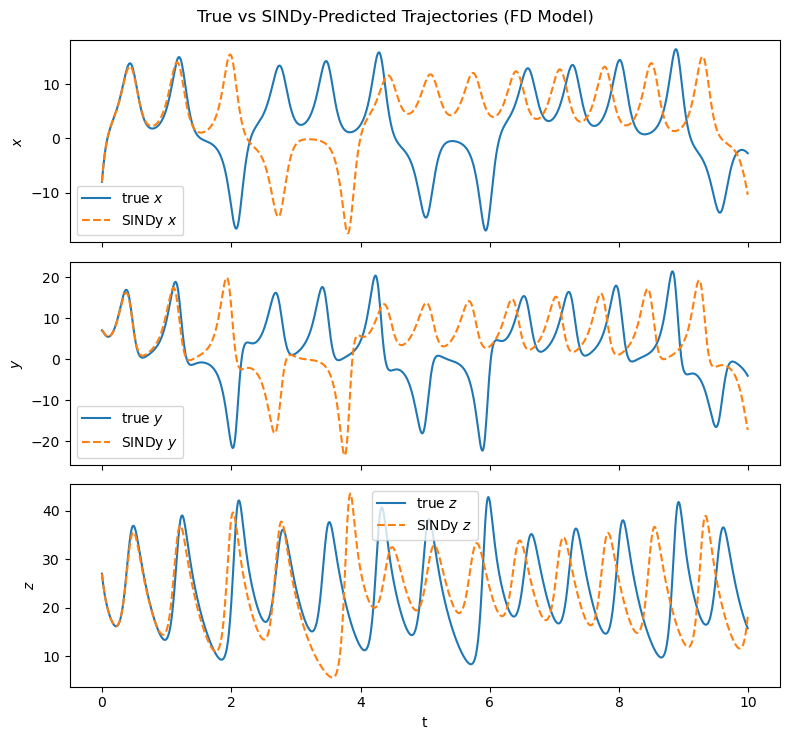

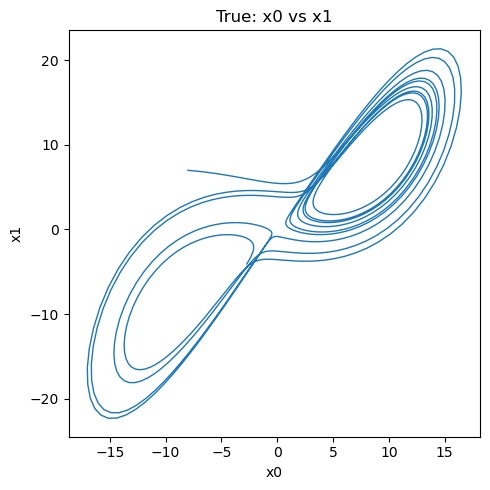

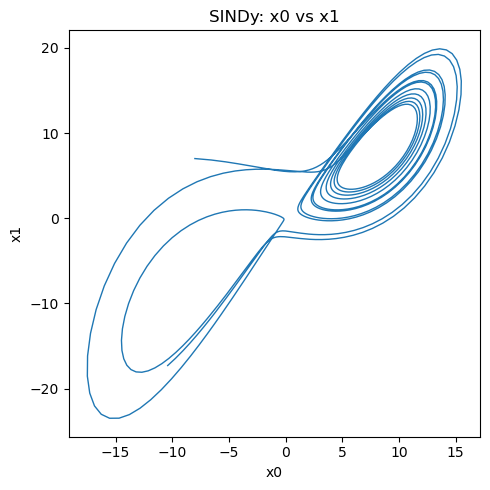

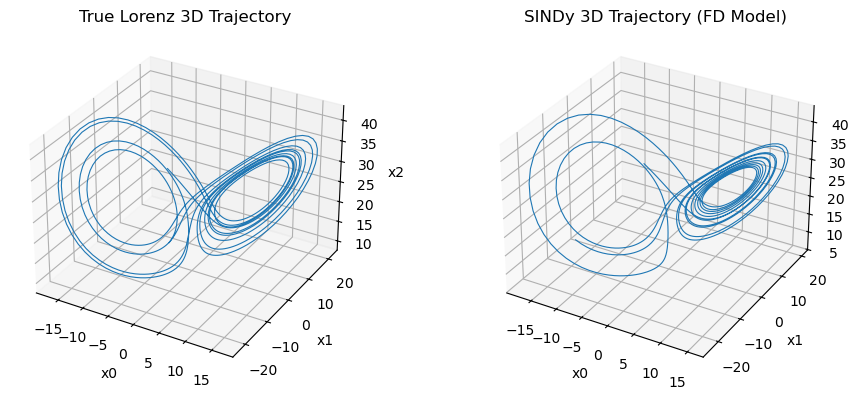

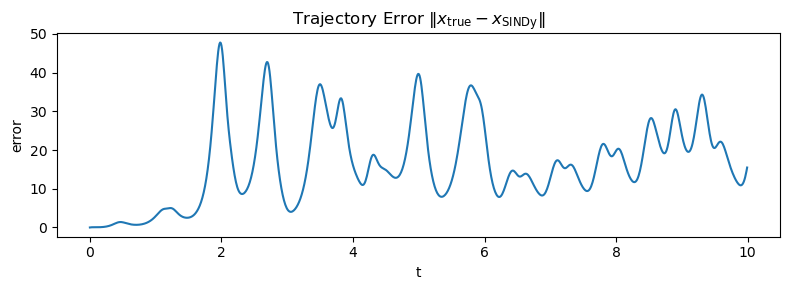

In [2]:
# ---------- 1. True Lorenz simulation ----------

lorenz_params = {"sigma": 10.0, "rho": 28.0, "beta": 8 / 3}
lorenz_x0 = jnp.array([-8.0, 7.0, 27.0])

lorenz = LorenzDefinition(
    parameters=lorenz_params,
    x0_vector=lorenz_x0,
    t0=0.0,
    tf=10.0,
    dt=0.01,
)

ts, xs = lorenz.simulate()  # ts: (N,), xs: (N, 3)


# ---------- 2. Finite-difference derivatives ----------

Xdot_fd = finite_difference_derivative(ts, xs)  # (N, 3)

# Crop ends for SINDy (avoid FD boundary artifacts)
crop = slice(1, -1)
X = xs[crop, :]
Xdot = Xdot_fd[crop, :]


# ---------- 3. Fit SINDy (FD baseline) ----------

cfg = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.2,
    n_iter=10,
    post_tol=1e-2,
    var_names=("x", "y", "z"),
)

model = SINDyModel(cfg).fit(X, Xdot)

print("=== SINDy model using finite-difference derivatives (baseline) ===")
model.print()


# ---------- 4. Simulate the learned SINDy model ----------

x0_true = np.asarray(xs[0, :])  # same IC as true system
xs_pred = model.simulate(x0_true, ts, method="rk4")  # (N, 3)
error_traj = np.linalg.norm(np.asarray(xs) - xs_pred, axis=1)


# ---------- 5. Plots using plotting.py + overlays ----------

labels = [r"$x$", r"$y$", r"$z$"]

# True time series
plot_time_series(
    ts,
    xs,
    labels=labels,
    title="Lorenz Time Series (True System)",
)

# SINDy-predicted time series
plot_time_series(
    ts,
    xs_pred,
    labels=labels,
    title="SINDy-Reconstructed Time Series (FD Model)",
)

# Overlay comparison
plot_time_series_comparison(
    ts,
    xs,
    xs_pred,
    labels=labels,
    title="True vs SINDy-Predicted Trajectories (FD Model)",
)

# Phase plots if you still want them
plot_phase(xs, i=0, j=1, title="True: x0 vs x1")
plot_phase(xs_pred, i=0, j=1, title="SINDy: x0 vs x1")

# 3D comparison
plot_3d_comparison(
    xs,
    xs_pred,
    indices=(0, 1, 2),
    title_true="True Lorenz 3D Trajectory",
    title_pred="SINDy 3D Trajectory (FD Model)",
)

# Error vs time
plot_error_time_series(
    ts,
    error_traj,
    title=r"Trajectory Error $\|x_{\mathrm{true}} - x_{\mathrm{SINDy}}\|$",
)